In [30]:
%load_ext autoreload
%autoreload 2
from datamodules import FMDataset, fm_collate, CFMDataset, SCFMDataset, cfm_collate, ot_collate
from arch import *
from flow_utils import compute_conditional_flow

import scvi
import torch
import numpy as np
import pytorch_lightning as pl
import os

import scanpy as sc

from torchcfm.conditional_flow_matching import *
import scanpy as sc
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# load some data
adata = sc.read_h5ad('/orcd/archive/abugoot/001/Projects/dlesman/datasets/kaggle_HVG.h5ad')

# here we set up the train/eval and control/pert sets
# set the idx of the controls
control_idx = adata.obs['sm_name'] == 'Dimethyl Sulfoxide'
# set the idx of the perts (currently just "all not control")
pert_idx = adata.obs['sm_name'] != 'Dimethyl Sulfoxide'
# set the hold out cell-type/pert
eval_cell_idx = adata.obs.cell_type == 'B cells'
eval_pert_idx = adata.obs['sm_name'] == 'Belinostat'
eval_idx = eval_cell_idx & eval_pert_idx

In [4]:
# here we set up our embeddings for cfm
# this is just so everything lives in obsm for the for loop below
adata.obsm["X"] = adata.X

# this is an example of how we can embed something using just the train idxs
# and then run fm on that embedding
# embedder = PCA(n_components=30).fit(adata.X[(control_idx | pert_idx) & ~eval_idx])
# adata.obsm["X_pca"] = embedder.transform(adata.X)

In [5]:
# here we set up the perts
import pandas as pd
perts = pd.get_dummies(adata.obs['sm_name']).values.astype(float)
pert_ids = perts.argmax(axis=1)
# this is the "identity featurization"; we can swap this matrix for
# any latent representation of perturbations we want but this is 
# a non-parametric featurization for right now
pert_mat = np.eye(pert_ids.max() + 1).astype('float32')

In [6]:
cell_types = pd.get_dummies(adata.obs.cell_type).values.argmax(axis=1)

In [7]:
X = adata.obsm['X']

# set train and eval split
control_train = X[control_idx & ~eval_idx]
pert_train = X[pert_idx & ~eval_idx]
pert_ids_train =  pert_ids[pert_idx & ~eval_idx]
control_cell_types = cell_types[control_idx & ~eval_idx]
pert_cell_types = cell_types[pert_idx & ~eval_idx]

control_eval = X[control_idx & eval_cell_idx]
pert_eval = X[eval_idx]
pert_ids_eval = pert_ids[eval_idx]

batch_size = 32

In [31]:
dset = CFMDataset(
    control_train, pert_train, 
    pert_ids_train, pert_mat, 
)
dl = torch.utils.data.DataLoader(dset, batch_size=batch_size, collate_fn=ot_collate)

In [32]:
model = CMLP(training_module=CFM, feat_dim=X.shape[1], cond_dim=pert_mat.shape[1], time_varying=True)

In [39]:
model = CMLP(training_module=MSE, feat_dim=X.shape[1], cond_dim=pert_mat.shape[1], time_varying=False)

In [40]:
next(iter(dl))[2].shape

torch.Size([32, 18])

In [41]:
# Train the model
trainer = pl.Trainer(
    gpus=1,  # Specify the number of GPUs to use
    max_epochs=100,  # Specify the maximum number of training epochs
)
# model = CMLP(feat_dim=X.shape[1], cond_dim=pert_mat.shape[1], time_varying=True)
trainer.fit(model, dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | combo_net | Sequential | 547 K 
1 | cond_net  | Sequential | 35.5 K
-----------------------------------------
582 K     Trainable params
0         Non-trainable params
582 K     Total params
2.330     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
from torch.utils.data import BatchSampler, SequentialSampler, Sampler
from typing import Iterator, Iterable, Optional, Sequence, List, TypeVar, Generic, Sized, Union


In [10]:
for embedding in ["X"]: # if we wanted to run in the PCA "latent" as well we would use ["X", "X_pca"]
    print(embedding)
    # set X to the (latent) counts
    X = adata.obsm[embedding]
    
    # set train and eval split
    control_train = X[control_idx & ~eval_idx]
    pert_train = X[pert_idx & ~eval_idx]
    pert_ids_train =  pert_ids[pert_idx & ~eval_idx]
    control_cell_types = cell_types[control_idx & ~eval_idx]
    pert_cell_types = cell_types[pert_idx & ~eval_idx]
    
    control_eval = X[control_idx & eval_cell_idx]
    pert_eval = X[eval_idx]
    pert_ids_eval = pert_ids[eval_idx]

    # set up data processing for cfm
    batch_size = 32
    dset = SCFMDataset(
        control_train, pert_train, 
        pert_ids_train, pert_mat, 
        control_cell_types, pert_cell_types,
        batch_size=batch_size
    )
    dl = torch.utils.data.DataLoader(
        dset, collate_fn=cfm_collate, 
        batch_sampler=StratifiedBatchSampler(
            SequentialSampler(dset), batch_size=batch_size, drop_last=True, 
            probs=dset.probs, num_strata=dset.num_strata
        )
    )
    
    # Train the model
    trainer = pl.Trainer(
        gpus=1,  # Specify the number of GPUs to use
        max_epochs=5_000,  # Specify the maximum number of training epochs
    )
    model = CMLP(feat_dim=X.shape[1], cond_dim=pert_mat.shape[1], time_varying=True)
    trainer.fit(model, dl)

    # Save the predicted perturbation
    torch.cuda.empty_cache()
    traj = compute_conditional_flow(model, control_eval, pert_ids_eval, pert_mat)

    np.savez(
        f"kaggle.{embedding}.cmlp.identity.strat.5k.npz", 
        pred_pert=traj[-1, :, :], true_pert=pert_eval, control=control_eval
    )

X


/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[0.11802492 0.17374211 0.19115699 0.43906356 0.053642   0.02437041]


/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | combo_net | Sequential | 266 K 
1 | cond_net  | Sequential | 17.9 K
-----------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.137     Total estimated model params size (MB)
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


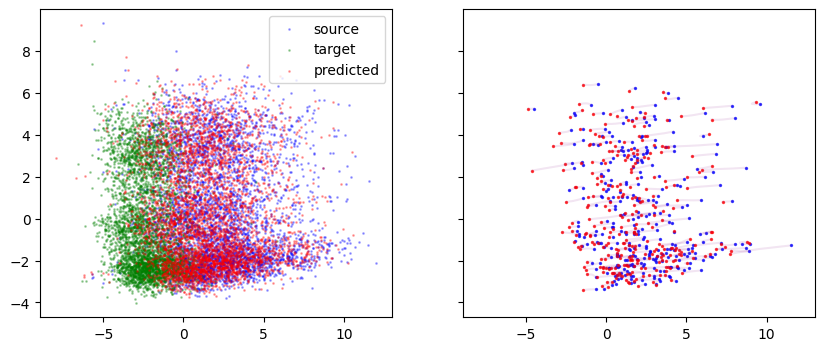

In [11]:
embedder = PCA(n_components=2).fit(adata.X[((control_idx & eval_cell_idx) | eval_idx)])

source_embed = embedder.transform(X[control_idx & eval_cell_idx])
target_embed = embedder.transform(X[eval_idx])
traj_embed = np.stack([embedder.transform(traj_i) for traj_i in traj])


fig = plt.figure(figsize=(10, 4))
axs = fig.subplots(1, 2, sharey=True, sharex=True)
k = 10_000
axs[0].scatter(source_embed[:k, 0], source_embed[:k, 1], alpha=0.3, s=1, label="source", color='blue')
axs[0].scatter(target_embed[:k, 0], target_embed[:k, 1], alpha=0.3, s=1, label="target", color='green')
axs[0].scatter(traj_embed[-1, :k, 0], traj_embed[-1, :k, 1], alpha=0.3, s=1, label="predicted", color='red')
axs[0].legend()

k = 300
axs[1].scatter(source_embed[:k, 0], source_embed[:k, 1], alpha=0.7, s=2, label="source", color='blue')
axs[1].scatter(traj_embed[-1, :k, 0], traj_embed[-1, :k, 1], alpha=0.7, s=2, label="predicted", color='red')

for i in range(k):
    axs[1].plot(traj_embed[:, i, 0].T, traj_embed[:, i, 1].T, color="purple", alpha=0.1)
plt.show()

In [ ]:
for embedding in ["X"]: # if we wanted to run in the PCA "latent" as well we would use ["X", "X_pca"]
    print(embedding)
    # set X to the (latent) counts
    X = adata.obsm[embedding]
    
    # set train and eval split
    control_train = X[control_idx & ~eval_idx]
    pert_train = X[pert_idx & ~eval_idx]
    pert_ids_train =  pert_ids[pert_idx & ~eval_idx]
    control_cell_types = cell_types[control_idx & ~eval_idx]
    pert_cell_types = cell_types[pert_idx & ~eval_idx]
    
    control_eval = X[control_idx & eval_cell_idx]
    pert_eval = X[eval_idx]
    pert_ids_eval = pert_ids[eval_idx]

    # set up data processing for cfm
    batch_size = 32
    dset = SCFMDataset(
        control_train, pert_train, 
        pert_ids_train, pert_mat, 
        control_cell_types, pert_cell_types,
        batch_size=batch_size
    )
    dl = torch.utils.data.DataLoader(
        dset, collate_fn=cfm_collate, 
        batch_sampler=StratifiedBatchSampler(
            SequentialSampler(dset), batch_size=batch_size, drop_last=True, 
            probs=dset.probs, num_strata=dset.num_strata
        )
    )

    # Train the model
    trainer = pl.Trainer(
        gpus=1,  # Specify the number of GPUs to use
        max_epochs=5_000,  # Specify the maximum number of training epochs
    )
    model = CMHA(feat_dim=X.shape[1], cond_dim=pert_mat.shape[1], time_varying=True)
    trainer.fit(model, dl)

    # Save the predicted perturbation
    torch.cuda.empty_cache()
    traj = compute_conditional_flow(model, control_eval, pert_ids_eval, pert_mat)
    
    np.savez(
        f"kaggle.{embedding}.cmha.identity.strat.5k.npz", 
        pred_pert=traj[-1, :, :], true_pert=pert_eval, control=control_eval
    )

X
[0.11802492 0.17374211 0.19115699 0.43906356 0.053642   0.02437041]


/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUD

Training: 0it [00:00, ?it/s]

In [ ]:
embedder = PCA(n_components=2).fit(adata.X[((control_idx & eval_cell_idx) | eval_idx)])

source_embed = embedder.transform(X[control_idx & eval_cell_idx])
target_embed = embedder.transform(X[eval_idx])
traj_embed = np.stack([embedder.transform(traj_i) for traj_i in traj])


fig = plt.figure(figsize=(10, 4))
axs = fig.subplots(1, 2, sharey=True, sharex=True)
k = 10_000
axs[0].scatter(source_embed[:k, 0], source_embed[:k, 1], alpha=0.3, s=1, label="source", color='blue')
axs[0].scatter(target_embed[:k, 0], target_embed[:k, 1], alpha=0.3, s=1, label="target", color='green')
axs[0].scatter(traj_embed[-1, :k, 0], traj_embed[-1, :k, 1], alpha=0.3, s=1, label="predicted", color='red')
axs[0].legend()

k = 300
axs[1].scatter(source_embed[:k, 0], source_embed[:k, 1], alpha=0.7, s=2, label="source", color='blue')
axs[1].scatter(traj_embed[-1, :k, 0], traj_embed[-1, :k, 1], alpha=0.7, s=2, label="predicted", color='red')

for i in range(k):
    axs[1].plot(traj_embed[:, i, 0].T, traj_embed[:, i, 1].T, color="purple", alpha=0.1)
plt.show()